### Caffe Lines classification

### 1. Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [23]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import glob
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import redis
from PIL import Image
from StringIO import StringIO
from sklearn import metrics 
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [3]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
#import sys
#caffe_root = '/home/oleksandr/Caffe/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
#sys.path.insert(0, caffe_root + 'python')

import caffe
from caffe.proto import caffe_pb2
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.|

### 2. Load net and set up input preprocessing

* Set Caffe to CPU mode and load the net from disk.

In [6]:
caffe.set_mode_gpu()

model_def = '/home/oleksandr/Caffe/lines/caffe_models/alexnet_22_09_2016_grey/caffenet_deploy_2.prototxt'
model_weights = '/home/oleksandr/Caffe/lines/caffe_models/alexnet_22_09_2016_grey/caffe_model_alexnet_iter_50000.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [7]:
mean_blob = caffe_pb2.BlobProto()
with open('/home/oleksandr/Caffe/lines/caffe_models/alexnet_22_09_2016_grey/mean.binaryproto') as f:
    mean_blob.ParseFromString(f.read())
mean_array = np.asarray(mean_blob.data, dtype=np.float32).reshape(
    (mean_blob.channels, mean_blob.height, mean_blob.width))
print (mean_array.shape)

(3, 227, 227)


In [9]:
# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mean_array)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

### 3. GPU classification

* Now we're ready to perform classification. Even though we'll only classify one image, we'll set a batch size of 50 to demonstrate batching.

In [11]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(1,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227

In [ ]:
image_path = '/home/oleksandr/Downloads/color_imgs_19_09/dow_2016_09_09/2016_09_09_queue_photo_out/'
images = []

for filename in glob.iglob(image_path + '*.jpg'):
    #if "line" in filename:
    images.append(filename)   
    
labels = [1- int("noqueue" in filename) for filename in images]

print ( "Images length: ", len(images))

def classify_images(y_pred, net_labels, images):
    for image in images:
        image = caffe.io.load_image(image)
        transformed_image = transformer.preprocess('data', image)
        net.blobs['data'].data[...] = transformed_image
        output = net.forward()
        output_prob = output['prob'][0]
        net_labels.append(output_prob.argmax())
        y_pred.append(output_prob[1])
        #print (output_prob[1], end= ' ')
        print (output_prob.argmax(), end= ' ')

y_pred = []
net_labels = []

classify_images(y_pred, net_labels, images)


### 3. Statistics

In [26]:
print(metrics.classification_report(labels, net_labels))

             precision    recall  f1-score   support

          0       0.79      0.94      0.86      2460
          1       0.68      0.32      0.43       903

avg / total       0.76      0.78      0.74      3363



In [27]:
def predict(y):
    threshold=0.2
    return np.array(y) > threshold

In [28]:
def show_result(y,predict):
    n_dec=20
    # строим децили размером N
    b=np.percentile(predict,np.linspace(0,100,n_dec+1))
    print ("Prob  Count  Count Count  Bad     Bad")
    print ("               Bad  Good  Rate,%  Rate,cum")
    for prob in map(lambda b0,b1: (b0,b1), b[:-1],b[1:]):
        print ("%5.2f" % (100*prob[0]) , end=',')
        range=(predict>=prob[0]) & (predict<prob[1])
        print ("%5i %6i %5i" % (sum(range), sum(y[range]), sum(range)-sum(y[range])), end=',')
        print ("%6.1f" % (y[range]*100).mean(), end=',')
        print ("%7.1f" % (y[predict>=prob[0]]*100).mean())
    print ("Gini = %5.1f%%" % (100*(1-2*(1- metrics.roc_auc_score(y, predict))))   )

In [29]:
def print_score(y,prob):
    pred = predict(prob)

    print ("acc:%5.3f Gini:%5.1f prec:%5.3f recall:%5.3f f1:%5.3f" % \
              (metrics.accuracy_score(y, pred),
               100*(1-2*(1- metrics.roc_auc_score(y, prob))),
               metrics.precision_score(y, pred),
               metrics.recall_score(y, pred),
               metrics.f1_score(y, pred)),  )   

In [30]:
print_score(np.array(labels), np.array(y_pred))

acc:0.780 Gini: 63.2 prec:0.619 recall:0.473 f1:0.536


In [31]:
show_result(np.array(labels), np.array(y_pred))

Prob  Count  Count Count  Bad     Bad
               Bad  Good  Rate,%  Rate,cum
 0.00,  169      0   169,   0.0,   26.9
 0.00,  168      5   163,   3.0,   28.3
 0.00,  168      6   162,   3.6,   29.7
 0.00,  168      9   159,   5.4,   31.2
 0.00,  168     10   158,   6.0,   32.8
 0.00,  168     12   156,   7.1,   34.6
 0.00,  168     16   152,   9.5,   36.6
 0.01,  168     19   149,  11.3,   38.7
 0.02,  168     32   136,  19.0,   40.9
 0.06,  168     32   136,  19.0,   42.9
 0.14,  169     41   128,  24.3,   45.3
 0.38,  168     34   134,  20.2,   47.7
 0.89,  168     58   110,  34.5,   51.1
 2.09,  168     59   109,  35.1,   53.4
 4.71,  168     70    98,  41.7,   56.5
10.50,  168     82    86,  48.8,   59.5
21.60,  168     86    82,  51.2,   62.1
39.69,  168     97    71,  57.7,   65.7
61.83,  168    114    54,  67.9,   69.7
81.37,  168    120    48,  71.4,   71.6
Gini =  63.2%


### 3. ROC 

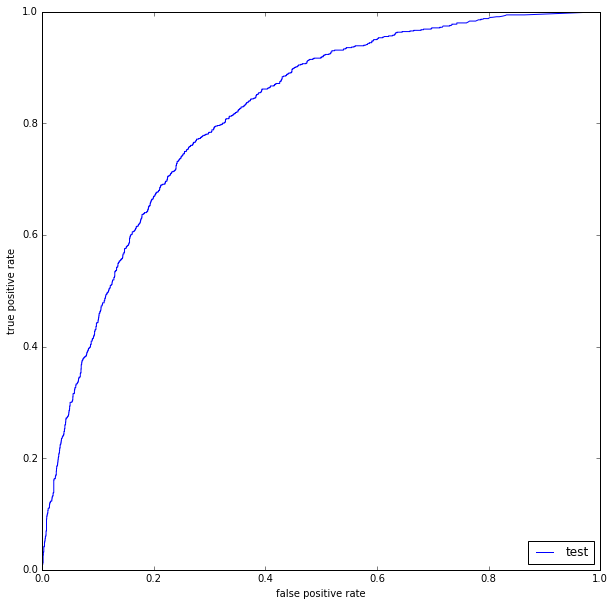

In [32]:
fpr, tpr, thr = metrics.roc_curve(np.array(labels), np.array(y_pred))
plt.plot(fpr, tpr,label="test")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc=4)

In [ ]:
def show_img(num):
    im_arr = np.asarray(Image.open(images[num]))
    plt.imshow(im_arr)
    print (images[num])
    print (net_labels[num])
    
show_img(3)